## Problem 3 ##

Note to Grader: This code VERY closely mimics the starter code provided in "Variational+Inference+Examples," since Dr. Brown explicitly said we should "use the existing code, and merely plug in the changes described in the homework problem." In fact, the infection array provided in the second part of this homework problem provides almost the same exact results as the starter code's ADVI approximation does. This raised a red flag for me, since I did only slightly modify the original code, but ultimately I believe this makes sense given the inputs are effectively the same. I changed the SEED randomizer to see how this would affect differences between my results and the starter code results. I also used a beta-binomial conjugate prior assumption, since the response variable was binary, and this was the only way I could assign the "true" posterior given the limited information provided in the homework prompt.

In [1]:
## Taken from "Variational Inference Examples" starter code.
# Modified and extended from AustinRochford, 2016 http://www.monetate.com/

from IPython.display import HTML

In [2]:
## Taken from "Variational Inference Examples" starter code.
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import seaborn as sns
import tensorflow as tf
from theano import shared, tensor as tt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
## Taken from "Variational Inference Examples" starter code.
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

In [57]:
## Taken from "Variational Inference Examples" starter code.
SEED = 20190520

np.random.seed(SEED)

In [28]:
## MV Gaussian parameter creation

sigma_11=1.0
sigma_22=np.sqrt(0.5)
corr=0.75
var_cov=np.array([[sigma_11**2, (sigma_11*sigma_22*corr)],
                 [sigma_11*sigma_22*corr,sigma_22**2]])
precision=np.linalg.inv(var_cov) # Multiplicative inverse
mean=np.array([1,2])
results=[0,1,0,1,1,0,0,0,0,0]
approx_sigma11,approx_sigma22=1/np.sqrt(np.diag(precision))
constant=1/(1-(corr**2))
constant

2.2857142857142856

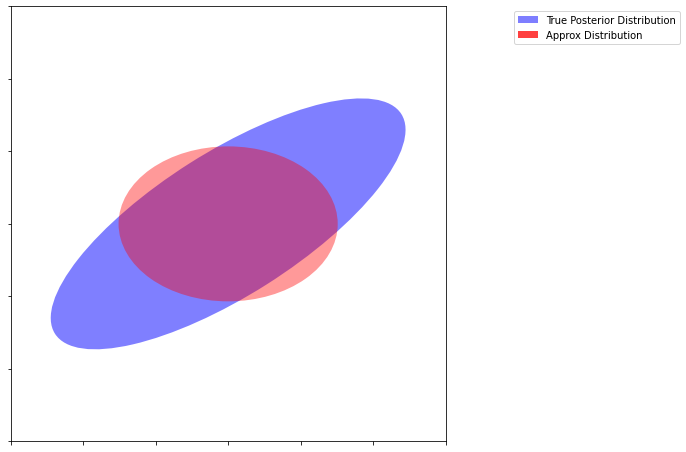

In [32]:
## Plot

fix, ax=plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
var,u=np.linalg.eig(var_cov)
angle=180. / np.pi*np.arccos(np.abs(u[0,0]))
e=Ellipse(np.zeros(2),2*np.sqrt(5.991*var[0]),2*np.sqrt(5.991*var[1]),angle=angle)
e.set_alpha(0.5)
e.set_facecolor("blue")
e.set_zorder(10)
ax.add_artist(e)
## Approximation
approx_e=Ellipse((0.0,0.0), 2*constant*approx_sigma11, 2*constant*approx_sigma22)
approx_e.set_alpha(0.4)
approx_e.set_facecolor("red")
approx_e.set_zorder(11)
ax.add_artist(approx_e)
ax.set_xlim(-3,3)
ax.set_xticklabels([])
ax.set_ylim(-3,3)
ax.set_yticklabels([])
rect=plt.Rectangle((0,0),1,1,fc="blue",alpha=.5)
rect2=plt.Rectangle((0,0),1,1,fc="red",alpha=.75)
ax.legend([rect,rect2],
         ["True Posterior Distribution",
          "Approx Distribution"],
         bbox_to_anchor=(1.55,1))

This approximation is produced using mean field factorization, which partitions components of the variables within an approximation distribution (q(z)) and treats them as independent independent. This creates a closed form solution for the approximation. I believe the approximation distribution visualized is spherical because the partitioned sigmas generated are multiplied by constants (function of the correlation), creating more spherical shape than the true posterior distribution. At a higher level, variational inference sacrifices the accuracy provided by sampling in favor of reduced computational complexity, producing a rough approximation of the posterior distribution instead. This can be visualized above.

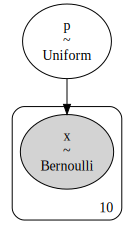

In [61]:
## Sore throat problem

x_beta_binomial = np.array(results)

with pm.Model() as beta_binomial_model:
    p_beta_binomial = pm.Uniform('p', 0., 1.)

with beta_binomial_model:
    x_obs = pm.Bernoulli('x', p_beta_binomial,
                         observed=x_beta_binomial)
pm.model_to_graphviz(beta_binomial_model)

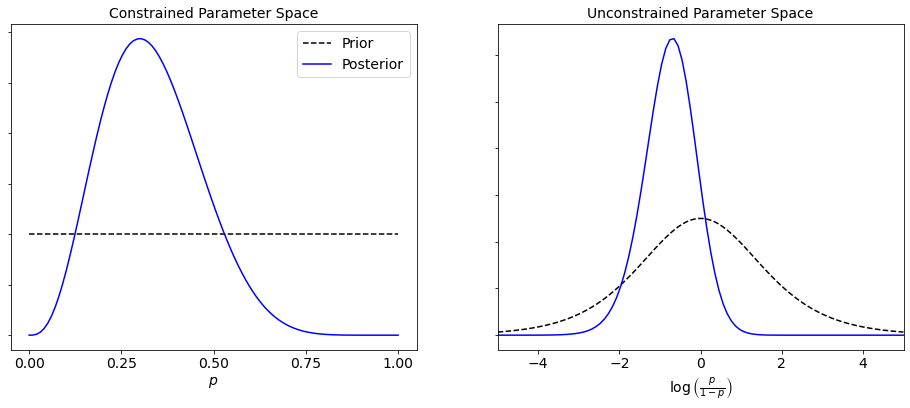

In [62]:

# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(),
                          1 + (1 - x_beta_binomial).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100)
const_ax.plot(const_x, prior.pdf(const_x),
              '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c='blue', label='Posterior');

const_ax.set_xticks(np.linspace(0, 1, 5));
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100)
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x),
              '--', c='k');
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x),
              c='blue');

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');

In [63]:
with beta_binomial_model:
    approx = pm.fit(40000, method = 'advi', random_seed = SEED)

Finished [100%]: Average Loss = 7.1977


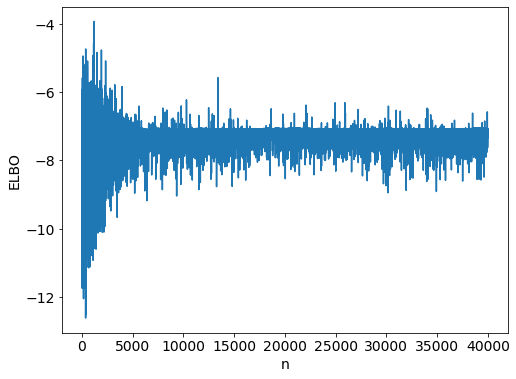

In [64]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

#plt.plot(approx.hist);

In [65]:
advi_bb_mu = approx.mean.eval()
advi_bb_std = approx.std.eval()
advi_bb_dist = sp.stats.norm(advi_bb_mu, advi_bb_std)
advi_bb_std

array([0.69799871])

<ipython-input-62-28aa49bf6d66>:15: RuntimeWarning: invalid value encountered in true_divide
  return pdf(x_logit) / (x * (1 - x))


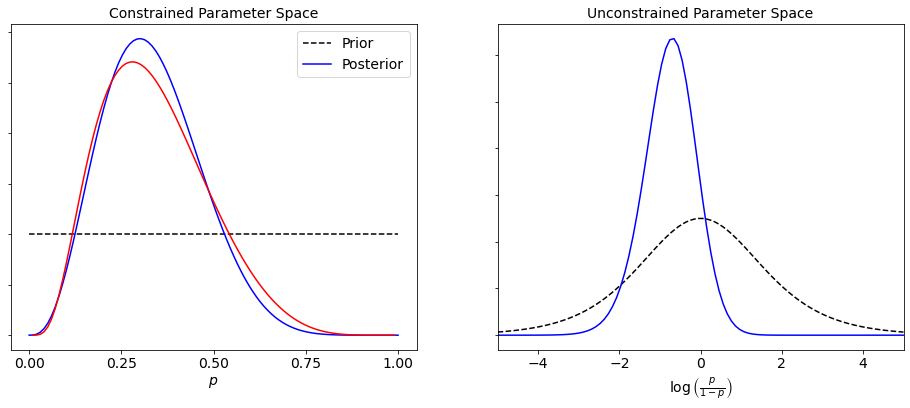

In [66]:
# plot the ADVI approximation to the true posterior
const_ax.plot(const_x, logit_trans_pdf(advi_bb_dist.pdf, const_x),
              c='red', label='Variational approximation');
fig